In [36]:
 
ngram_length = 1
dstype = 'cnews' 
mname = 'debertaV3'

In [37]:
from colorama import Fore, Style

import os

In [38]:
path = f"/home/bhairavi/om/om3/{dstype}/{ngram_length}grams_{mname}/"
os.makedirs(path, exist_ok=True)

print("Directory created or already exists.")
 

file_path = path + f'{dstype}_{ngram_length}keys.csv' 
print(Fore.YELLOW,"csv_filePATH--->",file_path)


filepath_full = path + f'{dstype}_{ngram_length}top5.csv' 
print(Fore.YELLOW,"QUE_filePATH--->",filepath_full)
 
 
 
modelpath = f"/home/bhairavi/om/om5/{dstype}/{mname}_{dstype}"

 

print(Fore.YELLOW,'modelPATH--->',modelpath)
 


Directory created or already exists.
 csv_filePATH---> /home/bhairavi/om/om3/cnews/1grams_debertaV3/cnews_1keys.csv
 QUE_filePATH---> /home/bhairavi/om/om3/cnews/1grams_debertaV3/cnews_1top5.csv
 modelPATH---> /home/bhairavi/om/om5/cnews/debertaV3_cnews


In [39]:

 
 
import torch  

torch.cuda.empty_cache()  
import pandas as pd
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertForSequenceClassification, BertTokenizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
 


# %%
from collections import defaultdict
import string
 
import torch.nn.functional as F
from nltk.util import ngrams

import numpy as np  
  


Maximum token length: 102
Next maximum token length: 95
Average token length: 32.94


Map: 100%|██████████| 1552/1552 [00:00<00:00, 4308.84 examples/s]


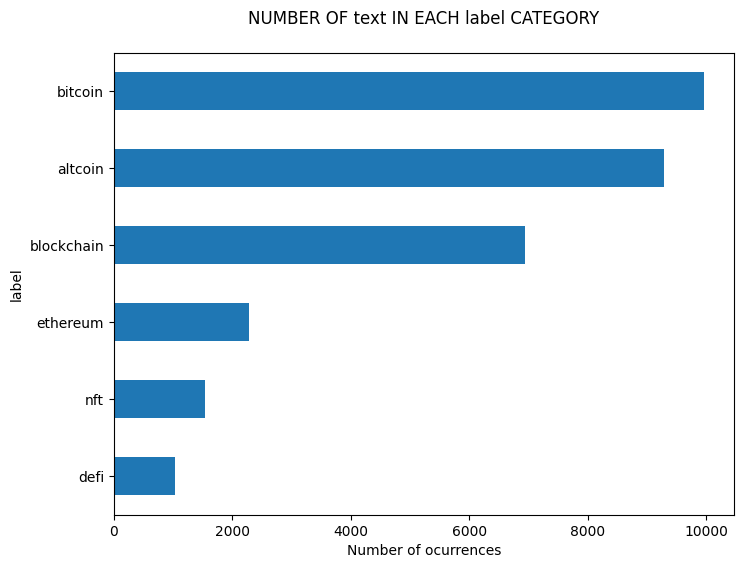

In [40]:


# %%
df = pd.read_csv('/home/bhairavi/om/om5/cnews/cryptonews.csv')



 
 
 
 


# %%

# %%

# %%
df.sample(5)


# %%


# %%
df['text']  = df['text'] + df['title']

# %%
df['label'] = df['subject']

# %%
df.columns

# %%


# %%

# %%
from sklearn.preprocessing import LabelEncoder

# %%
le = LabelEncoder()
df['target'] = le.fit_transform(df['label'])

# %%


# %%



# %%

# %%
fig = plt.figure(figsize=(8,6)) 
df.groupby('label').text.count().sort_values().plot.barh(
    ylim=0,   title= 'NUMBER OF text IN EACH label CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);


# %%


# %%

# %%
numlabel = df['target'].nunique()
numlabel


# %%
df = df[['text', 'target','label']]


# %%
df.columns

# %%
numlabel = df['target'].nunique()
numlabel


# %%
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = "cuda"  # the device to load the model onto

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(modelpath)
model = AutoModelForSequenceClassification.from_pretrained(modelpath, num_labels=numlabel)

# Move the model to the specified device
model.to(device)

# %%


# %%
df['token_length'] = df['text'].apply(lambda x: len(x.split()))

# Calculate the maximum token length
max_length = df['token_length'].max()
# Calculate the next maximum token length
next_max_token_length = df['token_length'].nlargest(2).iloc[1] 


# Calculate the average token length
average_token_length = df['token_length'].mean()

# Display the results
print(f"Maximum token length: {max_length}")
print(f"Next maximum token length: {next_max_token_length}") 
print(f"Average token length: {average_token_length:.2f}")

# %%
min(df['token_length'])


# %%

# %%
from sklearn.model_selection import StratifiedShuffleSplit

# Splitting off the test set with 5% of the data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)  # 5% for test
for train_val_idx, test_idx in sss.split(df, df['target']):
    train_val_df = df.iloc[train_val_idx]
    test_df = df.iloc[test_idx]

# Further split train_val_df into train and validation sets with validation set being 15.79% of the remaining data
# (which is equivalent to 15% of the original dataset size)
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)  # ~15.79% of remaining data
for train_idx, val_idx in sss_val.split(train_val_df, train_val_df['target']):
    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]
 

def tokenize_and_format(examples):
    # Tokenize the texts
    tokenized_inputs = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=max_length)
    tokenized_inputs['label'] = list(map(int, examples['target']))
    return tokenized_inputs

# Convert pandas DataFrame to Hugging Face's Dataset
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(val_df) 
test_dataset = Dataset.from_pandas(test_df)

# Map the tokenization function across the datasets
train_dataset = train_dataset.map(tokenize_and_format, batched=True,batch_size=16)
eval_dataset = eval_dataset.map(tokenize_and_format, batched=True,batch_size=16) 
test_dataset = test_dataset.map(tokenize_and_format, batched=True,batch_size=16)






In [41]:


# %%


# %%
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'eval_f1': f1,
        'eval_precision': precision,
        'eval_recall': recall,
    }

 

 
 

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Use 'epoch' to evaluate at the end of each epoch
    save_strategy="epoch",  # Also use 'epoch' to save at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,  # Load the best model at the end of training based on metric
    metric_for_best_model='f1',  # Define the metric for evaluating the best model
    logging_dir='./logs',
    logging_steps=10,
    report_to=[] 
)


 

trainer = Trainer(
    model=model,
    args=training_args ,  # Here you will need to make sure that the Trainer is set up correctly
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

 




/home/bhairavi/om/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [42]:

 
io=   pd.DataFrame(eval_dataset)
 
batch_size = 4

# Convert your DataFrame to a list of texts
texts = io['text'].tolist()

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the specified device
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Disable gradient calculations for efficiency
with torch.no_grad():
    # Initialize lists to store predictions
    all_predictions = []
    
    # Process data in batches
    for start in range(0, len(texts), batch_size):
        end = start + batch_size
        batch_texts = texts[start:end]
        
        # Tokenize the batch
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
        
        # Move inputs to the same device as model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Get predictions
        outputs = model(**inputs)
        # Apply softmax to get probabilities from the logits
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
        # Get the predicted class indices
        predicted_indices = torch.argmax(probabilities, dim=1)
        
        # Ensure the indices are back on CPU for DataFrame operations
        predicted_indices = predicted_indices.cpu()
        
        # Convert indices to actual labels if labels are strings
        if hasattr(tokenizer, 'get_labels') and callable(tokenizer.get_labels):
            predicted_labels = [tokenizer.get_labels()[idx] for idx in predicted_indices]
        else:
            predicted_labels = predicted_indices.tolist()
        
        # Append batch predictions to the list
        all_predictions.extend(predicted_labels)

# Add predictions to DataFrame
io['predicted_label'] = all_predictions
 


In [43]:
 

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# %%
top_n = 5
 
 
 
     


In [44]:
io[f'significant_{ngram_length}grams'] = None
io[f'{ngram_length}gram_weights'] = None 
def occlusion(text, model, tokenizer, label, ngram_length, device):
    inputs = tokenizer(text, return_tensors='pt').to(device)
    original_logits = model(**inputs).logits
    original_probs = F.softmax(original_logits, dim=-1)
    original_prediction = original_probs[0][label].item()
    ngram_importances = defaultdict(float)
    words = text.split()
    ngrams_list = list(ngrams(words, ngram_length))
    for ngram in ngrams_list:
        occluded_text = " ".join([word if word not in ngram else "[OCCLUDED]" for word in words])
        occluded_inputs = tokenizer(occluded_text, return_tensors='pt').to(device)
        occluded_logits = model(**occluded_inputs).logits
        occluded_probs = F.softmax(occluded_logits, dim=-1)
        occluded_prediction = occluded_probs[0][label].item()
        ngram_importances[" ".join(ngram)] = original_prediction - occluded_prediction
    return ngram_importances
def aggregate_and_filter_positive_attributions(ngram_attributions, threshold=0):
    significant_ngrams = {
        ngram: value for ngram, value in ngram_attributions.items()
        if value > threshold
    }
    return significant_ngrams
def select_top_ngrams(ngram_importances, top_n=top_n):
    sorted_ngrams = sorted(ngram_importances.items(), key=lambda item: item[1], reverse=True)
    top_ngrams = sorted_ngrams[:top_n]
    return top_ngrams
for index, row in io.iterrows():
    if row['target'] == row['predicted_label']:  
        ngram_attributions = occlusion(row['text'], model, tokenizer, row['label'], ngram_length, device)
        positive_attributions = aggregate_and_filter_positive_attributions(ngram_attributions)
        top_ngrams = select_top_ngrams(positive_attributions, top_n=top_n)  
        io.at[index, f'significant_{ngram_length}grams'] = [ngram for ngram, _ in top_ngrams]  
        io.at[index, f'{ngram_length}gram_weights'] = [weight for _, weight in top_ngrams] 


In [45]:
io.to_csv(filepath_full,index= False)
io[0:4]

,text,target,label,token_length,__index_level_0__,input_ids,token_type_ids,attention_mask,predicted_label,significant_1grams,1gram_weights
0,"Fed Chair Jerome Powell was 'all bark, no bite...",1,1,35,9338,"[1, 8053, 6079, 21254, 12533, 284, 382, 3068, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,"[Powell, Bitcoin, Fed, was, Jerome]","[0.0030794143676757812, 0.0027660131454467773,..."
1,Popular Decentralized exchange aggregator 1inc...,2,2,37,5903,"[1, 11067, 109070, 2395, 59818, 376, 5043, 265...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,"[Protocol.Popular, Coinbase's, network, Popula...","[0.27844108641147614, 0.2749921977519989, 0.22..."
2,Source: AdobeStock / GuGGGarThe consortium of ...,5,5,61,3232,"[1, 6583, 294, 8480, 34602, 840, 14766, 82608,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5,"[NFT, Yuga, Labs, Source:, /]","[0.696210190653801, 0.03912585973739624, 0.028..."
3,A handful of designers showcased Web3 initiati...,5,5,26,19929,"[1, 336, 6308, 265, 4906, 19002, 2277, 508, 52...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,None,None


In [46]:
 
io[f'significant_{ngram_length}grams'][0]
 
 


['Powell', 'Bitcoin', 'Fed', 'was', 'Jerome']

In [47]:


# %%

 
io['text'][0], io[f'significant_{ngram_length}grams'][0]



("Fed Chair Jerome Powell was 'all bark, no bite' with his hawkish comments which sent BTC price action below $25,000, says Material Indicators' Keith Alan.'Pick your targets’ — Bitcoin analyst believes Fed will favor bulls",
 ['Powell', 'Bitcoin', 'Fed', 'was', 'Jerome'])

In [48]:

# %%

# %%
io['label'] = le.inverse_transform(io['target'])

 


In [49]:


# %%
io= io.dropna()

# %%


In [50]:
# label_to_words = io.groupby('label')['significant_words'].apply(lambda words: set().union(*words)).to_dict()
label_to_words = io.groupby('label')[f'significant_{ngram_length}grams'].apply(lambda words: set().union(*words)).to_dict()
# label_to_words = io.groupby('label')['significant_5grams'].apply(lambda words: set().union(*words)).to_dict()
 
print(label_to_words)



{'altcoin': {'Ethereum', 'blockchain-related', '$3.9bn', 'break', 'BIC,', 'buy', 'Elliptic', 'Inu', 'over', 'around', 'Depegs', 'Dash', 'Tamadoge', 'last', 'CoinbaseÂ\\xa0has', 'grow', 'Ardoino', 'disclose', 'OKB', 'since', 'problem', '2%', 'America', 'herself', 'Token,', '8%', 'purpose', 'Release', 'Jumps', 'crypto', '11', 'wider', '“successfully”', 'market.\\xa0Bank', 'questioned', 'reported', 'October', 'contrasts', 'Binance,', 'Executive', 'Dawkins,', 'but', 'Scares', 'XRP', 'any', 'Probed', '\\x93Â\\xa0Where', 'multiple', 'week', 'Management', 'what', 'lays', 'here', 'FGHT,', 'Silvergate', 'USDC', 'issued', 'figures', 'had.XRP', 'tools,', 'Circle', 'it', 'indicator', 'Acquired', 'decentralized', 'For', 'pay,', 'Altcoins', 'for', 'Depressed', 'Train', 'According', 'short', 'Unciphered', 'Novi', 'UBS', 'withdrawal', 'major', 'Wang', 'GrayscaleÂ\\xa0CEOÂ\\xa0Michael', 'Crash?', 'Swastika-Themed', 'cryptoasset', 'Hate', 'sister', 'NEXO', 'all', 'amidst', 'set', 'McLaren', 'cryptocurre

In [51]:

# %%

# %%
 




label_to_words_and_weights = {}

for label, group in io.groupby('label'):
    word_weights_dict = {}
    for index, row in group.iterrows():
        words = row[f'significant_{ngram_length}grams']
        weights = row[f'{ngram_length}gram_weights']
        for word, weight in zip(words, weights):
            if word in word_weights_dict:
                # Take the maximum of the existing and current weight
                word_weights_dict[word] = max(word_weights_dict[word], weight)
            else:
                word_weights_dict[word] = weight
    label_to_words_and_weights[label] = word_weights_dict

# Display the dictionary with labels, words, and their maximum weights
print(label_to_words_and_weights)
 


{'altcoin': {'Price': 0.5656696911901236, 'its': 0.43322618305683136, 'Rally': 0.000841677188873291, 'have': 0.009679555892944336, 'and': 0.42523595690727234, 'Musk’s': 0.0019223690032958984, 'the': 0.4770030081272125, 'Worth': 0.001459658145904541, 'The': 0.08638519048690796, 'Sale': 0.0004030466079711914, 'is': 0.45712924003601074, 'of': 0.5151978135108948, 'could': 0.2646888494491577, '3%': 0.00023555755615234375, 'it': 0.0040724873542785645, 'price': 0.8651720434427261, 'in': 0.785880021750927, 'Chatbot': 0.04475820064544678, 'based': 0.039595723152160645, 'an': 0.240086168050766, 'Raises': 0.01343679428100586, 'Prediction': 0.7908362448215485, 'Tamadoge': 8.726119995117188e-05, 'Coin': 0.09126996994018555, '\\r\\n': 0.000769197940826416, 'thinks': 0.001841127872467041, 'sell-off.': 0.0001925826072692871, 'He': 0.00018781423568725586, 'Registrar': 0.007638394832611084, 'unicorn': 0.005190908908843994, 'equity': 0.004408419132232666, 'years': 0.0024596452713012695, 'or': 0.031390011

In [52]:

# %%


# %%
label_to_words = label_to_words_and_weights

# %%
 


In [53]:

# %%

# %%
len(label_to_words)



6

In [54]:

# %%

# %%
label_to_words

 


{'altcoin': {'Price': 0.5656696911901236,
  'its': 0.43322618305683136,
  'Rally': 0.000841677188873291,
  'have': 0.009679555892944336,
  'and': 0.42523595690727234,
  'Musk’s': 0.0019223690032958984,
  'the': 0.4770030081272125,
  'Worth': 0.001459658145904541,
  'The': 0.08638519048690796,
  'Sale': 0.0004030466079711914,
  'is': 0.45712924003601074,
  'of': 0.5151978135108948,
  'could': 0.2646888494491577,
  '3%': 0.00023555755615234375,
  'it': 0.0040724873542785645,
  'price': 0.8651720434427261,
  'in': 0.785880021750927,
  'Chatbot': 0.04475820064544678,
  'based': 0.039595723152160645,
  'an': 0.240086168050766,
  'Raises': 0.01343679428100586,
  'Prediction': 0.7908362448215485,
  'Tamadoge': 8.726119995117188e-05,
  'Coin': 0.09126996994018555,
  '\\r\\n': 0.000769197940826416,
  'thinks': 0.001841127872467041,
  'sell-off.': 0.0001925826072692871,
  'He': 0.00018781423568725586,
  'Registrar': 0.007638394832611084,
  'unicorn': 0.005190908908843994,
  'equity': 0.004408419

In [55]:

test_data = pd.DataFrame(test_dataset)
 
from nltk.tokenize import sent_tokenize, word_tokenize

# %%
def split_text(text):
 
    sentences = sent_tokenize(text)  # Tokenize the text into sentences
    third_index = len(sentences) // 2  # Calculate index for one-third
    first_part = ' '.join(sentences[:third_index])  # First third of sentences
    remaining_part = ' '.join(sentences[third_index:])  # Remaining two-thirds
    return first_part, remaining_part
 
# Apply the function to the DataFrame
test_data[['first_half', 'second_half']] = test_data['text'].apply(lambda x: pd.Series(split_text(x)))


# %%
test_data['first_half'][0:4] , test_data['second_half'][0:4]

# %%

 
# %%


(0    On December 26, major cryptocurrencies traded ...
 1                                                     
 2                                                     
 3                                                     
 Name: first_half, dtype: object,
 0    For weeks, cryptocurrency prices have been stu...
 1    The UK's Financial Conduct Authority (FCA) has...
 2    American crypto companies are quickly moving o...
 3    NFT Steez continues its conversation with the ...
 Name: second_half, dtype: object)

In [56]:

# %%
tdf = test_data[['first_half', 'label']]
tdf = Dataset.from_pandas(tdf)


 
   
def tokenize_function(examples):
    return tokenizer(examples['first_half'], truncation=True, padding="max_length", max_length=512)

tdf = tdf.map(tokenize_function, batched=True)

# Predict using the trained model
output = trainer.predict(tdf)
predictions = np.argmax(output.predictions, axis=1)
labels = output.label_ids 

# Generate the classification report
report = classification_report(
    labels,
    predictions,
    target_names=np.unique(labels).astype(str),  # Convert labels to string if necessary
    digits=4
)
print(Fore.RED +"first half i.e partial info classification report, baseline 1")
print(report)



Map: 100%|██████████| 1552/1552 [00:00<00:00, 4927.34 examples/s]


first half i.e partial info classification report, baseline 1
              precision    recall  f1-score   support

           0     0.8182    0.0776    0.1417       464
           1     0.6210    0.1546    0.2476       498
           2     0.2452    0.9625    0.3909       347
           3     0.0000    0.0000    0.0000        52
           4     0.4615    0.0526    0.0945       114
           5     0.8571    0.0779    0.1429        77

    accuracy                         0.2957      1552
   macro avg     0.5005    0.2209    0.1696      1552
weighted avg     0.5751    0.2957    0.2232      1552



In [57]:

model = model.to(device)

model.eval()

batch_size = 32  
 
with torch.no_grad():
    texts = test_data['first_half'].tolist()
    
    # Create empty lists to store results
    all_predicted_labels = []
    all_predicted_probs = []

    # Process the data in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize the batch
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

        # Move inputs to the same device as model
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get predictions
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
        
        # Get the top 3 predicted class indices and their probabilities
        top_probs, top_indices = torch.topk(probabilities, 3, dim=1)

        # Move to CPU for DataFrame operations
        top_indices = top_indices.cpu()
        top_probs = top_probs.cpu()

        # Convert indices to actual labels if labels are strings
        if hasattr(tokenizer, 'get_labels') and callable(tokenizer.get_labels):
            batch_predicted_labels = [[tokenizer.get_labels()[idx] for idx in indices] for indices in top_indices]
        else:
            batch_predicted_labels = top_indices.tolist()

        # Append results to the overall list
        all_predicted_labels.extend(batch_predicted_labels)
        all_predicted_probs.extend(top_probs.tolist())

    # Add the predictions and probabilities to the DataFrame
    test_data['top3_predicted_labels'] = all_predicted_labels
    test_data['top3_predicted_probabilities'] = all_predicted_probs



 


In [58]:
test_data = test_data[['text','label','target','first_half','second_half','top3_predicted_labels']]

# %%
test_data['top3_predicted_target']  =  test_data['top3_predicted_labels']

# %%
test_data['label'] = le.inverse_transform(test_data['target'])

# Decode 'top3_predicted_labels' - since these are lists, we apply the inverse transform in a vectorized manner
test_data['top3_predicted_labels'] = test_data['top3_predicted_labels'].apply(lambda x: le.inverse_transform(x))

 

# %%

# %%
def map_significant_words(predictions):
    print(predictions)
    for row in predictions:
        print(row)
    return [label_to_words.get(row, []) for row in predictions]
    # return [[result[pred] for pred in row] for row in predictions]

# Applying the mapping function
test_data['significant_words'] = test_data['top3_predicted_labels'].apply(map_significant_words)

# %%
test_data


['bitcoin' 'blockchain' 'altcoin']
bitcoin
blockchain
altcoin
['blockchain' 'altcoin' 'bitcoin']
blockchain
altcoin
bitcoin
['blockchain' 'altcoin' 'bitcoin']
blockchain
altcoin
bitcoin
['blockchain' 'altcoin' 'bitcoin']
blockchain
altcoin
bitcoin
['blockchain' 'altcoin' 'bitcoin']
blockchain
altcoin
bitcoin
['blockchain' 'altcoin' 'bitcoin']
blockchain
altcoin
bitcoin
['blockchain' 'altcoin' 'bitcoin']
blockchain
altcoin
bitcoin
['defi' 'blockchain' 'ethereum']
defi
blockchain
ethereum
['blockchain' 'altcoin' 'bitcoin']
blockchain
altcoin
bitcoin
['bitcoin' 'blockchain' 'altcoin']
bitcoin
blockchain
altcoin
['blockchain' 'nft' 'ethereum']
blockchain
nft
ethereum
['blockchain' 'altcoin' 'bitcoin']
blockchain
altcoin
bitcoin
['bitcoin' 'blockchain' 'altcoin']
bitcoin
blockchain
altcoin
['blockchain' 'altcoin' 'bitcoin']
blockchain
altcoin
bitcoin
['blockchain' 'altcoin' 'bitcoin']
blockchain
altcoin
bitcoin
['blockchain' 'altcoin' 'bitcoin']
blockchain
altcoin
bitcoin
['blockchain' 'alt

,text,label,target,first_half,second_half,top3_predicted_labels,top3_predicted_target,significant_words
0,"On December 26, major cryptocurrencies traded ...",altcoin,0,"On December 26, major cryptocurrencies traded ...","For weeks, cryptocurrency prices have been stu...","[bitcoin, blockchain, altcoin]","[1, 2, 0]","[{'Powell': 0.0030794143676757812, 'Bitcoin': ..."
1,The UK's Financial Conduct Authority (FCA) has...,bitcoin,1,,The UK's Financial Conduct Authority (FCA) has...,"[blockchain, altcoin, bitcoin]","[2, 0, 1]","[{'Protocol.Popular': 0.27844108641147614, 'Co..."
2,American crypto companies are quickly moving o...,altcoin,0,,American crypto companies are quickly moving o...,"[blockchain, altcoin, bitcoin]","[2, 0, 1]","[{'Protocol.Popular': 0.27844108641147614, 'Co..."
3,NFT Steez continues its conversation with the ...,ethereum,4,,NFT Steez continues its conversation with the ...,"[blockchain, altcoin, bitcoin]","[2, 0, 1]","[{'Protocol.Popular': 0.27844108641147614, 'Co..."
4,Binance is under investigation by French autho...,blockchain,2,,Binance is under investigation by French autho...,"[blockchain, altcoin, bitcoin]","[2, 0, 1]","[{'Protocol.Popular': 0.27844108641147614, 'Co..."
...,...,...,...,...,...,...,...,...
1547,Lawyer Kyle Roche previously withdrew as couns...,blockchain,2,,Lawyer Kyle Roche previously withdrew as couns...,"[blockchain, altcoin, bitcoin]","[2, 0, 1]","[{'Protocol.Popular': 0.27844108641147614, 'Co..."
1548,The patent protects claims for processing non-...,blockchain,2,,The patent protects claims for processing non-...,"[blockchain, altcoin, bitcoin]","[2, 0, 1]","[{'Protocol.Popular': 0.27844108641147614, 'Co..."
1549,The mining difficulty of the world's largest c...,bitcoin,1,,The mining difficulty of the world's largest c...,"[blockchain, altcoin, bitcoin]","[2, 0, 1]","[{'Protocol.Popular': 0.27844108641147614, 'Co..."
1550,Recent data shows over $1 billion worth of Eth...,ethereum,4,,Recent data shows over $1 billion worth of Eth...,"[blockchain, altcoin, bitcoin]","[2, 0, 1]","[{'Protocol.Popular': 0.27844108641147614, 'Co..."


In [59]:


# %%

# %%
test_data.to_csv(file_path,index= False)


In [60]:

# %%
df = test_data

 
df['significant_words'][0]

 


[{'Powell': 0.0030794143676757812,
  'Bitcoin': 0.994619278179016,
  'Fed': 0.12770909070968628,
  'was': 0.05730706453323364,
  'Jerome': 0.001392364501953125,
  'bridge': 0.02397751808166504,
  '5%.Bitcoin': 0.5736659169197083,
  '$1,265,': 0.11206835508346558,
  'XRP': 0.12203168869018555,
  '10%.': 0.10907268524169922,
  'price': 0.1252460777759552,
  'BTC': 0.9933576617040671,
  'rebounding': 0.0001519918441772461,
  'in': 0.7675748732872307,
  'targets': 0.00012218952178955078,
  '5%,': 0.10668104887008667,
  'over': 0.35977335274219513,
  'gained': 0.09634935855865479,
  '20%': 0.09448796510696411,
  'the': 0.9341297801584005,
  'is': 0.08438828587532043,
  'Going': 0.13549959659576416,
  'considered': 0.0006698369979858398,
  'of': 0.8614906184375286,
  'unexpected': 0.00045299530029296875,
  'addition': 0.0003311634063720703,
  'as': 0.4466772601008415,
  'Indicators.Bitcoin': 0.9917411261703819,
  'lack': 0.002255260944366455,
  'books': 0.002132117748260498,
  'Bitcoin’s': 0

In [61]:


# %%
# %%
df.rename(columns={'significant_words': 'significant_words_weights'}, inplace=True)
 


In [62]:
# %%
len(df['significant_words_weights'][0])


3

In [63]:

# %%
df['significant_words_weights'][0][0]  

# %%


{'Powell': 0.0030794143676757812,
 'Bitcoin': 0.994619278179016,
 'Fed': 0.12770909070968628,
 'was': 0.05730706453323364,
 'Jerome': 0.001392364501953125,
 'bridge': 0.02397751808166504,
 '5%.Bitcoin': 0.5736659169197083,
 '$1,265,': 0.11206835508346558,
 'XRP': 0.12203168869018555,
 '10%.': 0.10907268524169922,
 'price': 0.1252460777759552,
 'BTC': 0.9933576617040671,
 'rebounding': 0.0001519918441772461,
 'in': 0.7675748732872307,
 'targets': 0.00012218952178955078,
 '5%,': 0.10668104887008667,
 'over': 0.35977335274219513,
 'gained': 0.09634935855865479,
 '20%': 0.09448796510696411,
 'the': 0.9341297801584005,
 'is': 0.08438828587532043,
 'Going': 0.13549959659576416,
 'considered': 0.0006698369979858398,
 'of': 0.8614906184375286,
 'unexpected': 0.00045299530029296875,
 'addition': 0.0003311634063720703,
 'as': 0.4466772601008415,
 'Indicators.Bitcoin': 0.9917411261703819,
 'lack': 0.002255260944366455,
 'books': 0.002132117748260498,
 'Bitcoin’s': 0.9901368021965027,
 'to': 0.744

In [64]:
top_n = 15  # The number of top words you want to select

def filter_top_n_words(list_of_dicts):
    processed_list = []
    
    for index, dct in enumerate(list_of_dicts):
        if isinstance(dct, dict):
            # Sort the items by value in descending order
            sorted_items = sorted(dct.items(), key=lambda item: item[1], reverse=True)
            # Select the top N words
            top_items = sorted_items[:top_n]
            # Extract the keys (words) and add them to the list as a set
            processed_list.append(set(key for key, value in top_items))
        else:
            # Print the index and the problematic element
            print(f"Non-dictionary element at index {index}: {dct}")
            # Optionally, add an empty set or handle differently based on your needs
            processed_list.append(set())
    
    return processed_list

# Apply the function to each element in the DataFrame column
df['significant_words'] = df['significant_words_weights'].apply(filter_top_n_words)
 


In [65]:

# %%
df['significant_words'][0][0]  , df['significant_words'][0][1], df['significant_words'][0][2]


# %%


({'2021.Bitcoin',
  'BTC',
  'Bitcoin',
  'Bitcoin,',
  'Bitcoin.Bitcoin',
  'Bitcoin.Craig',
  'Bitcoin.\\xa0Bitcoin',
  'Bitcoin’s',
  'Indicators.Bitcoin',
  'bitcoin',
  'economy.\\xa0Bitcoin',
  'far.Bitcoin',
  "rally.'Bitcoin",
  'retailers.\\xa0Bitcoin',
  'trend.Bitcoin'},
 {'BlockFi',
  'Blockchain',
  'Blockchain-Focused',
  'Blockchain-Powered',
  'Blockchain-based',
  'UK.Gemini',
  "Web3.Nomura's",
  'Web3.Why',
  'assets.SEC',
  'blockchain',
  'blockchain-based',
  'blockchain.1inch',
  'blockchains,',
  'establish',
  'latest.Crypto-Focused'},
 {'2023?',
  'BTC,',
  'Cash?',
  'Ethereum',
  'Prediction',
  'Prediction:',
  'Stablecoin',
  '\\n\\nAs',
  'atÂ\\xa0Bernstein',
  'coins',
  'drops.Dogecoin',
  'in',
  'news.Today',
  'price',
  'projectÂ\\xa0FinSoulÂ\\xa0has'})

In [66]:

# %%
df.shape


# %%


(1552, 9)

In [67]:
 
df['significant_words'][0][0]  , df['significant_words_weights'][0][0] 



({'2021.Bitcoin',
  'BTC',
  'Bitcoin',
  'Bitcoin,',
  'Bitcoin.Bitcoin',
  'Bitcoin.Craig',
  'Bitcoin.\\xa0Bitcoin',
  'Bitcoin’s',
  'Indicators.Bitcoin',
  'bitcoin',
  'economy.\\xa0Bitcoin',
  'far.Bitcoin',
  "rally.'Bitcoin",
  'retailers.\\xa0Bitcoin',
  'trend.Bitcoin'},
 {'Powell': 0.0030794143676757812,
  'Bitcoin': 0.994619278179016,
  'Fed': 0.12770909070968628,
  'was': 0.05730706453323364,
  'Jerome': 0.001392364501953125,
  'bridge': 0.02397751808166504,
  '5%.Bitcoin': 0.5736659169197083,
  '$1,265,': 0.11206835508346558,
  'XRP': 0.12203168869018555,
  '10%.': 0.10907268524169922,
  'price': 0.1252460777759552,
  'BTC': 0.9933576617040671,
  'rebounding': 0.0001519918441772461,
  'in': 0.7675748732872307,
  'targets': 0.00012218952178955078,
  '5%,': 0.10668104887008667,
  'over': 0.35977335274219513,
  'gained': 0.09634935855865479,
  '20%': 0.09448796510696411,
  'the': 0.9341297801584005,
  'is': 0.08438828587532043,
  'Going': 0.13549959659576416,
  'considered'

In [68]:

# %%
# %%
df = df.dropna(ignore_index =True)


In [69]:
# %%
df.to_csv(file_path ,index= False)

# %%
df.columns


Index(['text', 'label', 'target', 'first_half', 'second_half',
       'top3_predicted_labels', 'top3_predicted_target',
       'significant_words_weights', 'significant_words'],
      dtype='object')

In [70]:

# %%
len(df['significant_words'][0]),len(df['significant_words'][0][0])

# %


(3, 15)